In [18]:
%matplotlib inline
import struct
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import scipy.misc as smp
hamming = np.array([0.54-0.46*np.cos(2*np.pi*i/511.0) for i in range(512)])

In [58]:
fs, w = wavfile.read('s1.wav') # fs = sample rate
w = w.T[0]

In [69]:
fbs = 256
amps = np.array([np.abs(np.fft.rfft(w[i*2*fbs:(i+1)*2*fbs]*hamming, 2*fbs))[:fbs] for i in range(0, (fs*30)//(2*fbs))])

In [70]:
def compute_acoustic_indices(w, total_length, t, fbs=256, fs=48000):
    """
    w : wav file
    total_length : total length of the recording (in seconds)
    t: time span for three indices (in seconds)
    fbs : number of frequency bins
    fs : sample rate of the wav file
    """
    freqs = np.linspace(0, fs/2, fbs)
    N = t*fs//(2*fbs) # number of cells in each time span
    aci_matrix = []
    h_t_matrix = []
    cvr_matrix = []
    for j in range(0, total_length//t): # for each time span
        amps = np.array([np.abs(np.fft.rfft(w[j*fs+i*2*fbs:j*fs+(i+1)*2*fbs]*hamming, 2*fbs))[:fbs] for i in range(0, N)]) # fft the corresponding segment
        aci = np.sum(np.abs(np.diff(amps,axis=0)),axis=0)/np.sum(amps,axis=0) # aci vector
#         aci_avg = np.average(aci[14:]) # remove low freqs, this is aci_index (not used at the moment)
        aci_matrix.append(aci)
        prob_masses = [amps[:,i]**2/np.sum(amps[:,i]**2) for i in range(0,fbs)] # entropy for each freq bin
        entropies = [entropy(e)/np.log2(N) for e in prob_masses] # H[t] vector
#         e = np.abs(np.fft.rfft(w))**2
#         h_t = entropy(e/np.sum(e))/np.log2(N) # entropy of the signal
        h_t_matrix.append(entropies)
    
        
        amps_mean = np.average(amps,axis=0)
        amps_std = np.std(amps,axis=0)
        noise = amps_mean+0.1*amps_std
        dbs = 20*np.log10(amps/noise)
        cvr = np.sum(dbs>2,axis=0)/dbs.shape[0] # cvr vector
#         cvr_avg = np.average(cvr[14:]) # cvr_index (not used)
        cvr_matrix.append(cvr)
    return freqs, np.array(aci_matrix), np.array(h_t_matrix), np.array(cvr_matrix), amps_mean

In [71]:
freq, aci_matrix, h_t_matrix, cvr_matrix, fft_mean = compute_acoustic_indices(w, 30, 30, fbs=256, fs=44100)

In [73]:
f = open("AI.TXT",'rb')
data = np.array([struct.unpack('f', f.read(4))[0] for i in range(256*4)])
data = data.reshape((256,4)).T

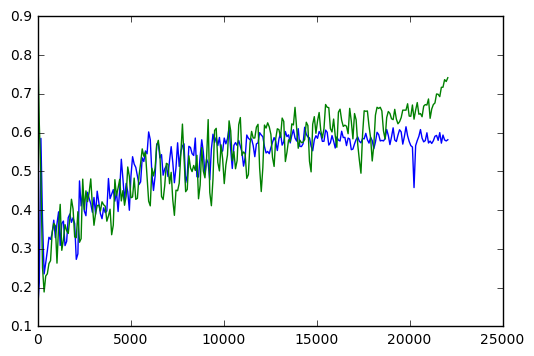

In [74]:
plt.plot(freq,data[0])
plt.plot(freq, aci_matrix[0])

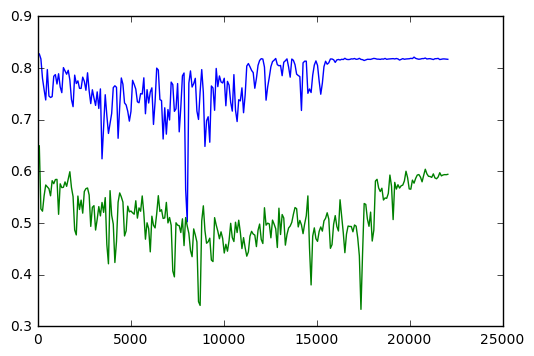

In [82]:
plt.plot(freq, data[1])
plt.plot(freq, h_t_matrix[0])

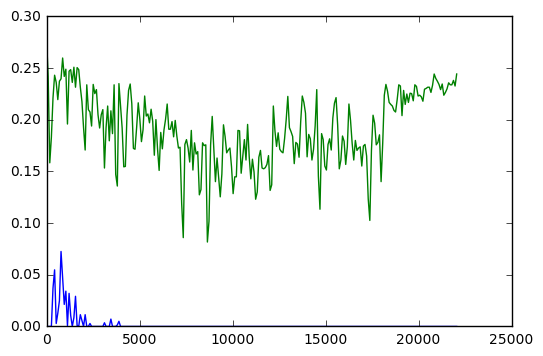

In [76]:
plt.plot(freq, data[2])
plt.plot(freq, cvr_matrix[0])

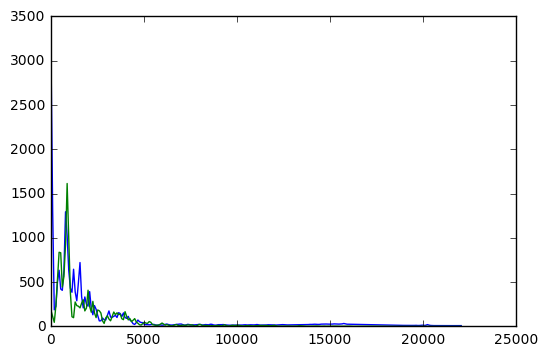

In [81]:
plt.plot(freq, data[3])
plt.plot(freq, fft_mean/256)